# Week 9 - PCA and Decision Trees

This week, we continue our work with dimensionality reduction with principal components analysis (PCA) and tree-based methods for function approximation: a class of methods for both classification and regression. 

## Lecture 22 - Implementing PCA

In [19]:
import numpy as np
import seaborn as sn
import time

from pprint import pprint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

In [2]:
# Principal component analysis
def PCA(X, alpha):        
    # find the original dimension and print it
    dimension = X.shape[1]
    print('The original dimension of the data is', dimension)
    
    # center D to have mean 0
    X -= np.mean(X, axis=0)
    
    # compute the covariance matrix
    Sigma = (1/X.shape[0]) * X.T @ X

    # compute the eigenvalues and eigenvectors of D^T D
    (eValues, eVectors) = np.linalg.eigh(Sigma)

    # compute the total variance
    varX = np.sum(eValues)
    
    # initialize the variance for A to 0
    varA = 0.0
    
    # reverse eValues and eVectors
    eValues = np.flip(eValues)
    eVectors = np.flip(eVectors, axis=1)

    # find the minimum dimension consisting of fraction at least alpha of the total variance
    for r in np.arange(0, eValues.shape[0]):
        varA += eValues[r]
        ratio = varA/varX

        if ratio > alpha:
            dimension = r + 1
            print('The new dimension of the data is', dimension, 'and it explains', ratio, 'of the variance')
            break
            
    # construct the new basis
    basis = eVectors[:,:dimension]
    
    # create the datapoints in the new space
    A = X @ basis
    
    # return points
    return A

To test this out a bit, let's bring in our neural network code and our favorite dataset (MNIST), use PCA to reduce the dimension of MNIST, and then train the neural net to classify the lower-dimensional data.

First, let's run it on MNIST images and compute the time. Later, we will compare it to using PCA and training the net on the resulting data.

Now training QDA...


G:\Miniconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA training is finished after 9.323522567749023 seconds
Now testing QDA...
QDA prediction is finished after 1.0325443744659424 seconds

Test Classification Report for reg_param = 0.05               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.97      0.94      0.95      1032
           3       0.96      0.94      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.94      0.95       892
           6       0.97      0.97      0.97       958
           7       0.97      0.93      0.95      1028
           8       0.91      0.94      0.93       974
           9       0.92      0.96      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Test Confusion Matrix:



<AxesSubplot:>

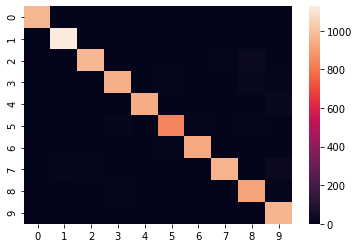

In [3]:
# import MNIST data
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

We achieved 96% accuracy on the test set and the run time was 9.5 seconds. Now, let's do exactly the same thing *except* we will use PCA to reduce the dimension of the same data before running QDA.

Now using PCA dimensionality reduction...
The original dimension of the data is 784
The new dimension of the data is 43 and it explains 0.8001734877104433 of the variance
PCA finished in 2.2605206966400146 seconds
Now training QDA...
QDA training is finished after 0.13000178337097168 seconds
Now testing QDA...
QDA prediction is finished after 0.04400181770324707 seconds

Test Classification Report for reg_param = 0.05               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1722
           1       0.98      0.98      0.98      2007
           2       0.95      0.97      0.96      1799
           3       0.95      0.94      0.95      1788
           4       0.98      0.97      0.97      1690
           5       0.95      0.97      0.96      1622
           6       0.98      0.97      0.98      1669
           7       0.96      0.95      0.96      1798
           8       0.93      0.94      0.93      1708
           9       0.94      0.94    

<AxesSubplot:>

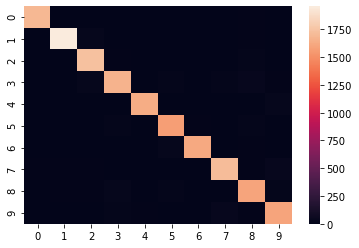

In [4]:
# import MNIST data
(trainX, trainY), (testX, testY) = mnist.load_data()

X = np.vstack((trainX, testX))
Y = np.concatenate((trainY, testY))

# reshape the data
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]).astype('float')

# Use PCA
print('Now using PCA dimensionality reduction...')

start = time.time()

# Apply PCA to the data matrices
X = PCA(X, 0.8)

end = time.time()

print('PCA finished in', end - start, 'seconds')

# normalize the data
X = X / 255.0

# train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Here, requiring a number of dimensions explaining 80\% of the variance of the dataset with PCA reduced the dimension from 784 to 43, a reduction of over 94\%! What is even more amazing is that the test accuracy on the lower-dimensional data is still 96\%, but the time for PCA (2.33 seconds) + training (0.13 seconds) + prediction (0.05 seconds) is only 2.5 seconds, less than a third the time as without PCA.

Let's try it with CIFAR-10, so let's see if performance improves or at least stays the same when we use PCA.

First, without PCA.

Now training QDA...


G:\Miniconda3\envs\DL\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


QDA training is finished after 153.28579878807068 seconds
Now testing QDA...
QDA prediction is finished after 9.90300965309143 seconds

Test Classification Report for reg_param = 0.05               precision    recall  f1-score   support

           0       0.55      0.39      0.46      1000
           1       0.88      0.19      0.31      1000
           2       0.33      0.41      0.37      1000
           3       0.30      0.32      0.31      1000
           4       0.31      0.75      0.44      1000
           5       0.44      0.41      0.42      1000
           6       0.92      0.11      0.19      1000
           7       0.84      0.31      0.46      1000
           8       0.33      0.89      0.48      1000
           9       0.81      0.20      0.32      1000

    accuracy                           0.40     10000
   macro avg       0.57      0.40      0.38     10000
weighted avg       0.57      0.40      0.38     10000


Test Confusion Matrix:



<AxesSubplot:>

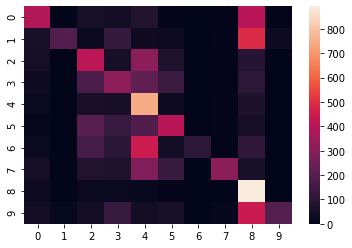

In [5]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], 3 * 32 * 32)
testX = testX.reshape(testX.shape[0], 3 * 32 * 32)

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Next, let's use PCA to shrink the data to a lower dimension and see how the runtime and performance compare with all settings equal.

Now using PCA dimensionality reduction...
The original dimension of the data is 3072
The new dimension of the data is 33 and it explains 0.8026871220318184 of the variance
PCA finished in 40.00347948074341 seconds
Now training QDA...
QDA training is finished after 0.09500312805175781 seconds
Now testing QDA...
QDA prediction is finished after 0.03199887275695801 seconds

Test Classification Report for reg_param = 0.05 :
               precision    recall  f1-score   support

           0       0.50      0.55      0.52      1473
           1       0.58      0.52      0.55      1500
           2       0.32      0.24      0.27      1492
           3       0.33      0.31      0.32      1491
           4       0.37      0.49      0.42      1516
           5       0.45      0.34      0.39      1514
           6       0.45      0.61      0.52      1503
           7       0.59      0.50      0.54      1570
           8       0.58      0.60      0.59      1493
           9       0.54      0.54 

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


<AxesSubplot:>

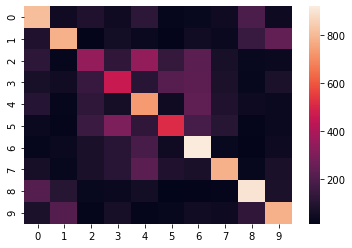

In [6]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

X = np.vstack((trainX, testX))
Y = np.concatenate((trainY, testY))

# reshape the data
X = X.reshape(X.shape[0], 3 * 32 * 32).astype('float')

# Use PCA
print('Now using PCA dimensionality reduction...')

start = time.time()

# Apply PCA to the data matrices
X = PCA(X, 0.8)

end = time.time()

print('PCA finished in', end - start, 'seconds')

# normalize the data
X = X / 255.0

# train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
print('Now training QDA...')

start = time.time()

model = QuadraticDiscriminantAnalysis(reg_param = 0.05)
model.fit(trainX, trainY)

end = time.time()

print('QDA training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing QDA...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('QDA prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report for reg_param =', 0.05, ':\n', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Performance is still not great, but it is better by 7% test accuracy. This is a huge win! Not only did we gain accuracy, but it took way less computation. This one took

* 39.5 seconds for PCA
* 0.4 seconds for training and testing

or 40 total seconds while training with the original dataset took 162 seconds.

Let's try kNN.

Now training kNN...


<ipython-input-7-85d8acf0c8c3>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(trainX, trainY)


kNN training is finished after 13.875126361846924 seconds
Now testing kNN...
kNN prediction is finished after 321.2794873714447 seconds

Test Classification Report               precision    recall  f1-score   support

           0       0.46      0.55      0.50      1000
           1       0.70      0.24      0.36      1000
           2       0.27      0.43      0.33      1000
           3       0.34      0.22      0.27      1000
           4       0.26      0.53      0.35      1000
           5       0.45      0.31      0.37      1000
           6       0.38      0.35      0.36      1000
           7       0.67      0.31      0.42      1000
           8       0.42      0.72      0.53      1000
           9       0.71      0.28      0.40      1000

    accuracy                           0.39     10000
   macro avg       0.47      0.39      0.39     10000
weighted avg       0.47      0.39      0.39     10000


Test Confusion Matrix:



<AxesSubplot:>

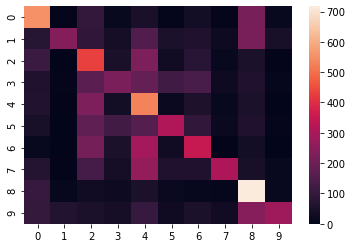

In [7]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], 3 * 32 * 32)
testX = testX.reshape(testX.shape[0], 3 * 32 * 32)

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# fit the model to the training data
print('Now training kNN...')

start = time.time()

model = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', p = 1, n_jobs = -1)
model.fit(trainX, trainY)

end = time.time()

print('kNN training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing kNN...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('kNN prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

Next, let's use PCA to shrink the data to a lower dimension and see how the runtime and performance compare with all settings equal.

Now using PCA dimensionality reduction...
The original dimension of the data is 3072
The new dimension of the data is 33 and it explains 0.8026871220318184 of the variance
PCA finished in 41.071492195129395 seconds
Now training kNN...
kNN training is finished after 0.14600110054016113 seconds
Now testing kNN...


<ipython-input-13-0830ac04e3d3>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(trainX, trainY)


kNN prediction is finished after 9.113002061843872 seconds

Test Classification Report               precision    recall  f1-score   support

           0       0.49      0.58      0.53      1473
           1       0.64      0.35      0.45      1500
           2       0.30      0.41      0.35      1492
           3       0.37      0.21      0.27      1491
           4       0.30      0.45      0.35      1516
           5       0.45      0.28      0.34      1514
           6       0.34      0.57      0.43      1503
           7       0.61      0.40      0.48      1570
           8       0.50      0.65      0.56      1493
           9       0.59      0.36      0.44      1448

    accuracy                           0.42     15000
   macro avg       0.46      0.42      0.42     15000
weighted avg       0.46      0.42      0.42     15000


Test Confusion Matrix:



<AxesSubplot:>

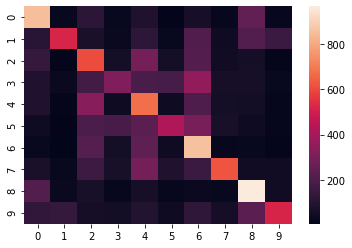

In [13]:
# import CIFAR-10 data
(trainX, trainY), (testX, testY) = cifar10.load_data()

X = np.vstack((trainX, testX))
Y = np.concatenate((trainY, testY))

# reshape the data
X = X.reshape(X.shape[0], 3 * 32 * 32).astype('float')

# Use PCA
print('Now using PCA dimensionality reduction...')

start = time.time()

# Apply PCA to the data matrices
X = PCA(X, 0.8)

end = time.time()

print('PCA finished in', end - start, 'seconds')

# normalize the data
X = X / 255.0

# train-test split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
print('Now training kNN...')

start = time.time()

model = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', p = 1, n_jobs = -1)
model.fit(trainX, trainY)

end = time.time()

print('kNN training is finished after', end - start, 'seconds')

# predict the labels of the test set
print('Now testing kNN...')

start = time.time()

predictedY = model.predict(testX)

end = time.time()

print('kNN prediction is finished after', end - start, 'seconds')

# print quality metrics
print('\nTest Classification Report', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

In [23]:
for alpha in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:
    
    print('\nalpha is', alpha)

    # import CIFAR-10 data
    (trainX, trainY), (testX, testY) = cifar10.load_data()

    X = np.vstack((trainX, testX))[:10000]
    Y = np.concatenate((trainY, testY))[:10000]

    # reshape the data
    X = X.reshape(X.shape[0], 3 * 32 * 32).astype('float')
        
    start = time.time()

    # Use PCA
    print('Now using PCA dimensionality reduction...')

    # Apply PCA to the data matrices
    X = PCA(X, alpha)

    end = time.time()

    print('PCA finished in', end - start, 'seconds')

    # normalize the data
    X = X / 255.0

    # train-test split
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

    # fit the model to the training data
    print('Now training kNN with gridsearch CV...')

    model = KNeighborsClassifier(n_jobs = -1)

    #define the hyperarameters we're trying to train
    parameters = {'weights' : ['uniform', 'distance'], 'n_neighbors' : [5, 7, 9, 10, 15, 20, 25, 30], 'p' : [0.5, 1, 1.5, 2]}
    
    clf = GridSearchCV(model, parameters, cv = 5, n_jobs = -1)

    clf.fit(trainX, trainY)

    end = time.time()

    print('kNN training is finished after', end - start, 'seconds')

    # predict the labels of the test set
    print('Now testing kNN...')

    start = time.time()

    predictedY = clf.predict(testX)

    end = time.time()

    print('kNN prediction is finished after', end - start, 'seconds')
    
    pprint(clf.best_params_)

    # print quality metrics
    print('\nTest Classification Report:\n', classification_report(testY, predictedY))

    print('\nTest Confusion Matrix:\n', confusion_matrix(testY, predictedY))


alpha is 0.7
Now using PCA dimensionality reduction...
The original dimension of the data is 3072
The new dimension of the data is 14 and it explains 0.7009413331923741 of the variance
PCA finished in 6.942036151885986 seconds
Now training kNN with gridsearch CV...


G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 20.67019557952881 seconds
Now testing kNN...
kNN prediction is finished after 0.24699950218200684 seconds
{'n_neighbors': 25, 'p': 1.5, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.49      0.48       254
           1       0.56      0.26      0.36       256
           2       0.25      0.32      0.28       260
           3       0.26      0.10      0.15       268
           4       0.24      0.30      0.27       263
           5       0.42      0.24      0.31       225
           6       0.28      0.57      0.37       230
           7       0.45      0.28      0.34       267
           8       0.41      0.55      0.47       249
           9       0.40      0.43      0.41       228

    accuracy                           0.35      2500
   macro avg       0.37      0.35      0.34      2500
weighted avg       0.37      0.35      0.34      2500


Test Confusion Matri

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 24.887680292129517 seconds
Now testing kNN...
kNN prediction is finished after 0.26600193977355957 seconds
{'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.51      0.48       254
           1       0.61      0.27      0.38       256
           2       0.24      0.35      0.29       260
           3       0.32      0.12      0.17       268
           4       0.26      0.32      0.28       263
           5       0.43      0.22      0.29       225
           6       0.26      0.57      0.35       230
           7       0.60      0.29      0.39       267
           8       0.43      0.60      0.50       249
           9       0.49      0.40      0.44       228

    accuracy                           0.36      2500
   macro avg       0.41      0.37      0.36      2500
weighted avg       0.41      0.36      0.36      2500


Test Confusion Matrix

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 34.502777099609375 seconds
Now testing kNN...
kNN prediction is finished after 0.4780006408691406 seconds
{'n_neighbors': 10, 'p': 1.5, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.51      0.48       254
           1       0.65      0.25      0.37       256
           2       0.26      0.37      0.30       260
           3       0.31      0.15      0.20       268
           4       0.27      0.40      0.32       263
           5       0.49      0.24      0.33       225
           6       0.28      0.56      0.37       230
           7       0.51      0.27      0.35       267
           8       0.43      0.58      0.49       249
           9       0.52      0.39      0.45       228

    accuracy                           0.37      2500
   macro avg       0.42      0.37      0.37      2500
weighted avg       0.42      0.37      0.36      2500


Test Confusion Matri

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 53.04801893234253 seconds
Now testing kNN...
kNN prediction is finished after 0.18100214004516602 seconds
{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.48      0.46       254
           1       0.66      0.24      0.35       256
           2       0.24      0.37      0.29       260
           3       0.30      0.12      0.17       268
           4       0.26      0.41      0.32       263
           5       0.43      0.20      0.27       225
           6       0.25      0.51      0.34       230
           7       0.57      0.27      0.36       267
           8       0.41      0.65      0.50       249
           9       0.56      0.33      0.41       228

    accuracy                           0.36      2500
   macro avg       0.41      0.36      0.35      2500
weighted avg       0.41      0.36      0.35      2500


Test Confusion Matrix:

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 89.49709486961365 seconds
Now testing kNN...
kNN prediction is finished after 0.20999836921691895 seconds
{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.51      0.50       254
           1       0.75      0.18      0.29       256
           2       0.24      0.38      0.29       260
           3       0.26      0.11      0.15       268
           4       0.24      0.44      0.31       263
           5       0.48      0.21      0.30       225
           6       0.25      0.47      0.32       230
           7       0.61      0.25      0.35       267
           8       0.41      0.66      0.50       249
           9       0.55      0.27      0.36       228

    accuracy                           0.35      2500
   macro avg       0.43      0.35      0.34      2500
weighted avg       0.42      0.35      0.34      2500


Test Confusion Matrix:

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 187.73541378974915 seconds
Now testing kNN...
kNN prediction is finished after 0.2830023765563965 seconds
{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.47      0.46       254
           1       0.77      0.16      0.27       256
           2       0.22      0.38      0.28       260
           3       0.27      0.10      0.15       268
           4       0.23      0.47      0.31       263
           5       0.45      0.20      0.28       225
           6       0.25      0.40      0.31       230
           7       0.56      0.21      0.30       267
           8       0.38      0.67      0.49       249
           9       0.58      0.21      0.31       228

    accuracy                           0.33      2500
   macro avg       0.42      0.33      0.31      2500
weighted avg       0.42      0.33      0.31      2500


Test Confusion Matrix:

G:\Miniconda3\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


kNN training is finished after 571.972081899643 seconds
Now testing kNN...
kNN prediction is finished after 1.6680028438568115 seconds
{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

Test Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.45      0.44       254
           1       0.83      0.11      0.20       256
           2       0.21      0.38      0.27       260
           3       0.25      0.11      0.15       268
           4       0.21      0.46      0.29       263
           5       0.39      0.19      0.26       225
           6       0.24      0.33      0.28       230
           7       0.55      0.17      0.26       267
           8       0.37      0.67      0.48       249
           9       0.57      0.18      0.27       228

    accuracy                           0.31      2500
   macro avg       0.40      0.31      0.29      2500
weighted avg       0.40      0.31      0.29      2500


Test Confusion Matrix:
 [

## Lecture 23: Decision Tree Classifiers

We will use the following (slightly modified) tutorial from https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html.

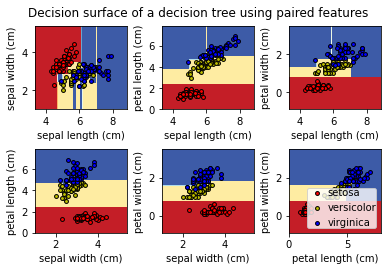

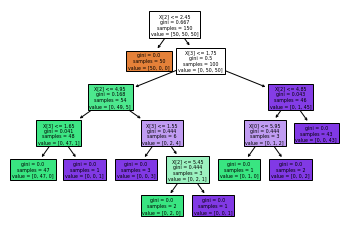

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

# hyperparameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load the iris dataset
iris = load_iris()

# run the model for each pair of features
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # fit the classifier
    clf = DecisionTreeClassifier().fit(X, y)

    # plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    # predict the testing data on a tight mesh of points in space and color-code them
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

plt.figure()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.show()

### Pruning the Tree

We will use some ideas from the `scikit-learn` documentation at https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

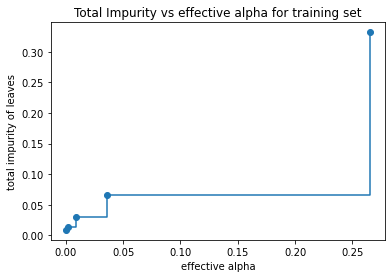

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# create the classifier
clf = DecisionTreeClassifier(random_state=0)

# do cost-complexity pruning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# plotting the impurities for different alphas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value in `ccp_alphas` is the alpha value that prunes the whole tree, leaving the tree, `clfs[-1]`, with one node.

In [10]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.332795493197279


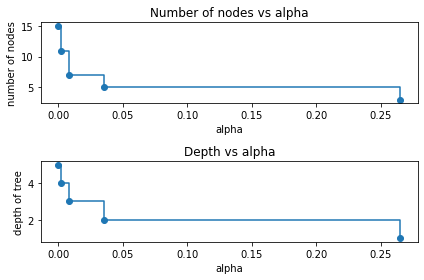

In [5]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

For the remainder of this example, we remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

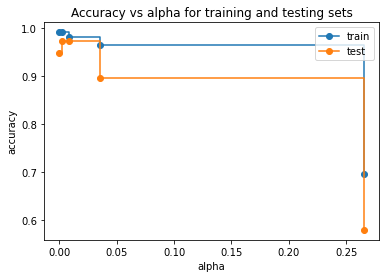

In [6]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

When `ccp_alpha` is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting `ccp_alpha = 0.015` maximizes the testing accuracy.

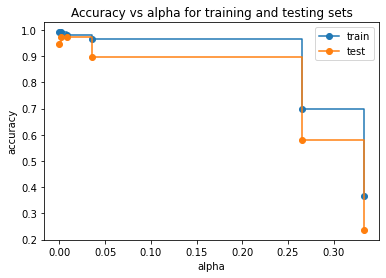

In [11]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()